This notebook provides examples for
1. Weight matching & activation matching between two models.
2. REPAIR/RESCALE/RESET
3. Homogeneous normalization

In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
from source.utils.utils import load_model
from source.utils.data_funcs import load_data
from source.utils.weight_matching import weight_matching
from source.utils.activation_matching import activation_matching
from source.utils.connect import eval_line, interpolate_state_dicts, repair, reset_bn_stats
from source.utils.logger import Logger
from torch.utils.data import DataLoader
from source.utils.train import validate
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class config:
    model = 'cifar_vgg16'
    dataset = 'cifar10'
    special_init = 'vgg_init' # 'vgg_init' (kaiming init) or None (uniform init)
    print_freq = 100
    data_dir = '../../Linear_Mode_Connectivity/data'
    n = 3 # number of interpolation points

In [4]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

trainset, testset = load_data(config.data_dir, config.dataset)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

trainset_noaug, _ = load_data(config.data_dir, config.dataset, no_random_aug=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
model_1, model_2 = load_model(config).to(device), load_model(config).to(device)

sd_1 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_20/model_1_160.pt', map_location=device)
sd_2 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_20/model_2_160.pt', map_location=device)

model_1.load_state_dict(sd_1)
model_2.load_state_dict(sd_2)

<All keys matched successfully>

Matching

In [ ]:
sd_2_wm, _ = weight_matching(config.model, sd_1, sd_2, device=device)
sd_2_am, _ = activation_matching(config.model, model_1, model_2, trainloader_noaug, 100, device) # no obvious difference found between trainloader and trainloader_noaug

Directly test the midpoint

In [7]:
sd_mid = interpolate_state_dicts(sd_1, sd_2, 0.5)
sd_wm_mid = interpolate_state_dicts(sd_1, sd_2_wm, 0.5)

model_test = load_model(config).to(device)
model_test.load_state_dict(sd_mid)
loss_mid, acc_mid, _, _ = validate(testloader, model_test, criterion, device, config)

model_test.load_state_dict(sd_wm_mid)
loss_wm_mid, acc_wm_mid, _, _ = validate(testloader, model_test, criterion, device, config)

print(f'Original midpoint: {loss_mid}, {acc_mid}%')
print(f'WM midpoint: {loss_wm_mid}, {acc_wm_mid}%')

[2024-01-29 11:01:58] (23936) {utils.py:69}INFO - Test: [ 1/40]	Time  0.041 ( 0.041)	Loss 2.4956e+00 (2.4956e+00)	Acc@1   8.98 (  8.98)	Acc@5  46.48 ( 46.48)
[2024-01-29 11:01:59] (23936) {utils.py:74}INFO -  *   Acc@1 10.000 Acc@5 50.000
[2024-01-29 11:01:59] (23936) {utils.py:69}INFO - Test: [ 1/40]	Time  0.032 ( 0.032)	Loss 2.6634e+00 (2.6634e+00)	Acc@1  10.16 ( 10.16)	Acc@5  70.31 ( 70.31)
[2024-01-29 11:02:00] (23936) {utils.py:74}INFO -  *   Acc@1 10.540 Acc@5 72.860


Original midpoint: 2.473850326538086, 10.0%
WM midpoint: 2.62109563369751, 10.54%


Apply REPAIR/RESCALE to the midpoint model

In [8]:
model_2_wm = load_model(config).to(device)
model_2_wm.load_state_dict(sd_2_wm)

model_test_repaired = repair(trainloader, [model_1, model_2_wm], model_test, device, [0.5, 0.5], variant='repair', name=config.model)
model_test_rescaled = repair(trainloader, [model_1, model_2_wm], model_test, device, [0.5, 0.5], variant='rescale', name=config.model)

In [9]:
loss_wm_mid_repaired, acc_wm_mid_repaired, _, _ = validate(testloader, model_test_repaired, criterion, device, config)
loss_wm_mid_rescaled, acc_wm_mid_rescaled, _, _ = validate(testloader, model_test_rescaled, criterion, device, config)

print(f'Repaired WM midpoint: {loss_wm_mid_repaired}, {acc_wm_mid_repaired}%')
print(f'Rescaled WM midpoint: {loss_wm_mid_rescaled}, {acc_wm_mid_rescaled}%')

[2024-01-29 11:03:01] (23936) {utils.py:69}INFO - Test: [ 1/40]	Time  0.046 ( 0.046)	Loss 1.3300e+00 (1.3300e+00)	Acc@1  59.77 ( 59.77)	Acc@5  85.55 ( 85.55)
[2024-01-29 11:03:02] (23936) {utils.py:74}INFO -  *   Acc@1 64.550 Acc@5 85.920
[2024-01-29 11:03:02] (23936) {utils.py:69}INFO - Test: [ 1/40]	Time  0.035 ( 0.035)	Loss 9.4065e-01 (9.4065e-01)	Acc@1  82.81 ( 82.81)	Acc@5  98.44 ( 98.44)
[2024-01-29 11:03:04] (23936) {utils.py:74}INFO -  *   Acc@1 84.520 Acc@5 98.350


Repaired WM midpoint: 1.2418409372329713, 64.55%
Rescaled WM midpoint: 0.8617645483970642, 84.52%


Create the interpolation plot

In [ ]:
lmc_wm = eval_line(model_1, model_2_wm, testloader, criterion, device, config, n=config.n)
lmc_wm_repair = eval_line(model_1, model_2_wm, testloader, criterion, device, config, n=config.n, repair='repair', name=config.model, bn_loader=trainloader)
lmc_wm_rescale = eval_line(model_1, model_2_wm, testloader, criterion, device, config, n=config.n, repair='rescale', name=config.model, bn_loader=trainloader)

Homogeneous normalization

In [11]:
lmc_wm_norm = eval_line(model_1, model_2_wm, testloader, criterion, device, config, n=config.n, bias_norm=True)

[2024-01-29 11:05:28] (23936) {utils.py:69}INFO - Test: [ 1/40]	Time  0.083 ( 0.083)	Loss 3.3725e-01 (3.3725e-01)	Acc@1  93.36 ( 93.36)	Acc@5 100.00 (100.00)
[2024-01-29 11:05:31] (23936) {utils.py:74}INFO -  *   Acc@1 91.860 Acc@5 99.560
[2024-01-29 11:05:31] (23936) {utils.py:69}INFO - Test: [ 1/40]	Time  0.079 ( 0.079)	Loss 4.9008e-01 (4.9008e-01)	Acc@1  92.58 ( 92.58)	Acc@5  99.22 ( 99.22)
[2024-01-29 11:05:34] (23936) {utils.py:74}INFO -  *   Acc@1 91.910 Acc@5 99.460
d:\OneDrive - Mohamed Bin Zayed University of Artificial Intelligence\桌面\Repos\icml2024_rethink\notebooks\..\source\utils\connect.py:41: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1420.)
  model_state[p_name].add_(1.0 - weight, state_dict_1[p_name])
[2024-01-2

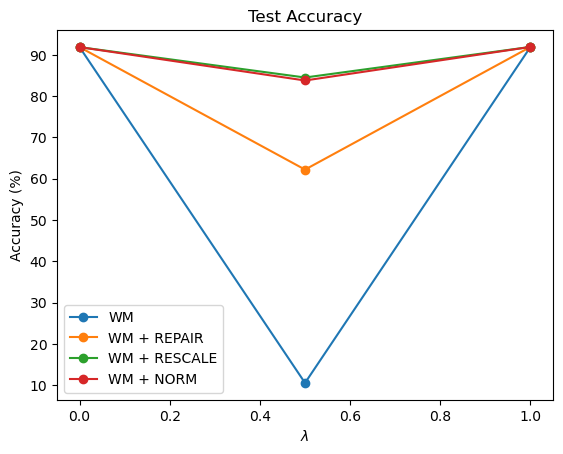

In [12]:
x_axis = np.linspace(0, 1, n)

plt.plot(x_axis, lmc_wm[:, 1], label='WM', marker='o')
plt.plot(x_axis, lmc_wm_repair[:, 1], label='WM + REPAIR', marker='o')
plt.plot(x_axis, lmc_wm_rescale[:, 1], label='WM + RESCALE', marker='o')
plt.plot(x_axis, lmc_wm_norm[:, 1], label='WM + NORM', marker='o')

plt.title('Test Accuracy')
plt.xlabel(r'$\lambda$')
plt.ylabel('Accuracy (%)')
plt.legend()

Example of RESET on ResNet20

In [13]:
config.model = 'cifar_resnet20_4x'
config.special_init = None

In [14]:
model_1, model_2 = load_model(config).to(device), load_model(config).to(device)

sd_1 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_10/model_1_160.pt', map_location=device)
sd_2 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_10/model_2_160.pt', map_location=device)

model_1.load_state_dict(sd_1)
model_2.load_state_dict(sd_2)

<All keys matched successfully>

In [ ]:
sd_2_wm, _ = weight_matching(config.model, sd_1, sd_2, device=device)

model_2_wm = load_model(config).to(device)
model_2_wm.load_state_dict(sd_2_wm)

In [16]:
sd_mid = interpolate_state_dicts(sd_1, sd_2, 0.5)
sd_wm_mid = interpolate_state_dicts(sd_1, sd_2_wm, 0.5)

model_test = load_model(config).to(device)
model_test.load_state_dict(sd_mid)
loss_mid, acc_mid, _, _ = validate(testloader, model_test, criterion, device, config)

model_test.load_state_dict(sd_wm_mid)
loss_wm_mid, acc_wm_mid, _, _ = validate(testloader, model_test, criterion, device, config)

# reset
reset_bn_stats(model_test, device, trainloader)
loss_wm_mid_reset, acc_wm_mid_reset, _, _ = validate(testloader, model_test, criterion, device, config)

print(f'Original midpoint: {loss_mid}, {acc_mid}%')
print(f'WM midpoint: {loss_wm_mid}, {acc_wm_mid}%')
print(f'WM midpoint (RESET): {loss_wm_mid_reset}, {acc_wm_mid_reset}%')

[2024-01-29 11:05:38] (23936) {utils.py:69}INFO - Test: [ 1/40]	Time  0.094 ( 0.094)	Loss 3.0721e+00 (3.0721e+00)	Acc@1   9.77 (  9.77)	Acc@5  50.00 ( 50.00)
[2024-01-29 11:05:41] (23936) {utils.py:74}INFO -  *   Acc@1 10.410 Acc@5 50.470
[2024-01-29 11:05:42] (23936) {utils.py:69}INFO - Test: [ 1/40]	Time  0.092 ( 0.092)	Loss 4.2899e+00 (4.2899e+00)	Acc@1  13.67 ( 13.67)	Acc@5  51.56 ( 51.56)
[2024-01-29 11:05:45] (23936) {utils.py:74}INFO -  *   Acc@1 15.160 Acc@5 54.200
[2024-01-29 11:06:11] (23936) {utils.py:69}INFO - Test: [ 1/40]	Time  0.088 ( 0.088)	Loss 7.1488e-01 (7.1488e-01)	Acc@1  82.42 ( 82.42)	Acc@5  98.83 ( 98.83)
[2024-01-29 11:06:14] (23936) {utils.py:74}INFO -  *   Acc@1 81.410 Acc@5 98.560


Original midpoint: 3.080922511291504, 10.41%
WM midpoint: 4.2666960647583005, 15.16%
WM midpoint (RESET): 0.7724548491477966, 81.41%


In [ ]:
lmc_ori = eval_line(model_1, model_2, testloader, criterion, device, config, n=config.n)
lmc_wm = eval_line(model_1, model_2_wm, testloader, criterion, device, config, n=config.n)
lmc_wm_reset = eval_line(model_1, model_2_wm, testloader, criterion, device, config, n=config.n, reset_bn=True, bn_loader=trainloader)

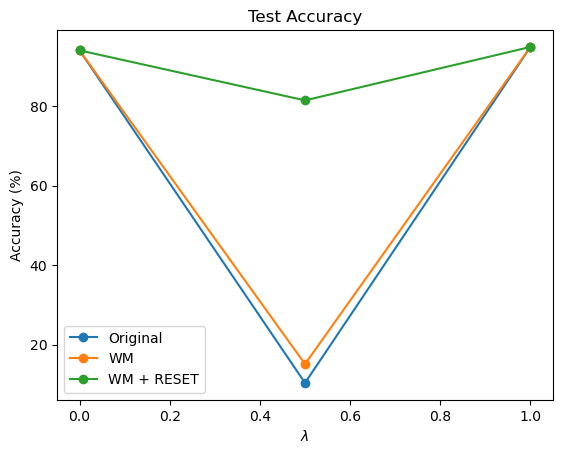

In [18]:
x_axis = np.linspace(0, 1, config.n)

plt.plot(x_axis, lmc_ori[:, 1], label='Original', marker='o')
plt.plot(x_axis, lmc_wm[:, 1], label='WM', marker='o')
plt.plot(x_axis, lmc_wm_reset[:, 1], label='WM + RESET', marker='o')

plt.title('Test Accuracy')
plt.xlabel(r'$\lambda$')
plt.ylabel('Accuracy (%)')
plt.legend()